In [1]:
#importing libaries and initialising my network
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.graph_objects as go
#from plotly.colors import n_colorsy
import Deep_Neural_Network_Script
import mpmath
from sklearn.preprocessing import MinMaxScaler

torch.cuda.empty_cache()

#device = torch.device("cpu")

#model
poly_model = Deep_Neural_Network_Script.RecurrentNeuralNetwork(
    number_of_hidden_layers = 2, #5, 100
    input_layer_size = 1,  
    hidden_layer_size = 500, #500
    output_layer_size = 1, 
    device_used = 'cpu',
    dropout=0.1
)
#add sequence length, add batch size
#use yeah boi
#'LSTM_2x500_run1.pth'
#saved_model2 = 'LSTM_2x500_run1_part3.pth' yeah boi
#saved_model1 = 'LSTM_2x500_run1_part2.pth' #total 4000 epochs
#torch.save(poly_model.state_dict(),saved_model)
#saved_model2 = 'LSTM_2x500_run2.pth' yeah boi
saved_model2 = 'LSTM_2x500_run3.pth'
#poly_model.load_state_dict(torch.load(saved_model2))

In [2]:
#fast fourier transfrom network for time series

In [3]:
#collecting data from csv file
file_name_I1 = 'GlobalTemperatures.csv'
I1_data = pd.read_csv(file_name_I1)
Cummulative_days = I1_data['days ']
Mean_temp = I1_data['Land Average Temperature']
Mean_temp_uncertainty = I1_data['Temp uncertainty']

Cleaned_mean_temp = []
Cleaned_cummulative_days = []
for i in range(int(len(Mean_temp)/12)):
    Cleaned_mean_temp.append(sum(Mean_temp[12*i: 12*(i+1)])/12)
    Cleaned_cummulative_days.append(sum(Cummulative_days[12*i: 12*(i+1)])/12)
#disregarding pre 1850 data due to unreliablily and noise
Cleaned_cummulative_days = np.array(Cleaned_cummulative_days[128:])
Cleaned_mean_temp = np.array(Cleaned_mean_temp[128:])
#Cleaned_cummulative_days = np.array(Cleaned_cummulative_days)
#Cleaned_mean_temp = np.array(Cleaned_mean_temp)

#apply an fft to the Cleaned_mean_temp
fft_Cleaned_mean_temp = np.fft.fft(Cleaned_mean_temp)


normalised_Cummulative_days = (Cleaned_cummulative_days-min(Cleaned_cummulative_days))/(max(Cleaned_cummulative_days)-min(Cummulative_days))
#normalised_Mean_temp = fft_Cleaned_mean_temp/max(fft_Cleaned_mean_temp)
normalised_Mean_temp = (Cleaned_mean_temp-min(Cleaned_mean_temp))/(max(Cleaned_mean_temp)-min(Cleaned_mean_temp))

#normalise the data between 0 and 1
#divisor = 5 #temporary noise filter, should really fft or moving average
#normalised_Mean_temp = torch.tensor(np.array(Mean_temp[::divisor])/(max(Mean_temp)-min(Mean_temp))).to(poly_model.device_used)
#normalised_Mean_temp_uncertainty = torch.tensor(np.array(Mean_temp_uncertainty[::divisor])/(max(Mean_temp)-min(Mean_temp))).to(poly_model.device_used)
#normalised_Cummulative_days = torch.tensor(np.array(Cummulative_days[::divisor])/max(Cummulative_days)).to(poly_model.device_used)

#normalised_Cummulative_days = np.linspace(0,10,200)
#normalised_Mean_temp = np.sin(normalised_Cummulative_days)
#define sequence lists from the data set
#should this not be the input size
sequence_length = 3 #as tech advancements happen roughly every decade
X, y = [], []
for i in range(len(normalised_Cummulative_days) - sequence_length):
    X.append(normalised_Cummulative_days[i:i + sequence_length])
    y.append(normalised_Mean_temp[i + sequence_length]) #next time step

#convert lists to numpy arrays

X = np.array(X) 
y = np.array(y)





#split into training and validation sets
proportion_training_set = 0.9
train_size = int(len(X) * proportion_training_set)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

#convert the numpy arrays to pytorch tensors
X_train_tensor = torch.tensor(X_train, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)
X_val_tensor = torch.tensor(X_val, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)
y_val_tensor = torch.tensor(y_val, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)

print(X_train_tensor.shape)
#batch the data
batch_size = 3 #1000

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)



torch.Size([120, 3, 1])


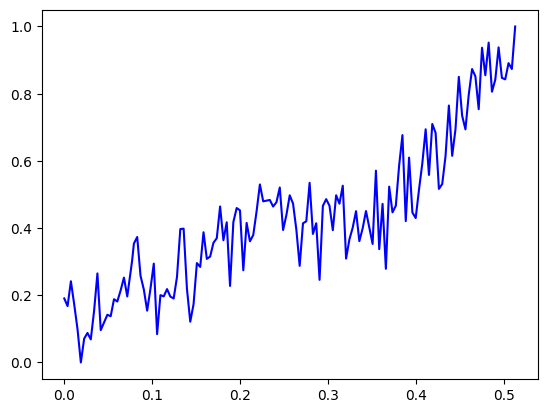

In [4]:
#plt.plot(normalised_Cummulative_days, np.fft.ifft(normalised_Mean_temp), 'red')
plt.plot(normalised_Cummulative_days, normalised_Mean_temp, 'blue')
#plt.plot(normalised_Cummulative_days, np.fft.ifft(np.fft.fft(normalised_Mean_temp)), 'blue')

In [5]:

#training the model
num_epochs = 2000 #10000
#batch_size = 100
freq = 50#size of each array collected below
loss_array, iteration_array, val_loss_array, lr_array = np.zeros(int(freq)), np.zeros(int(freq)), np.zeros(int(freq)), np.zeros(int(freq))
i_indication = 0
collection_rate = int(num_epochs/(freq))
loss_function = Deep_Neural_Network_Script.RMSLELoss()
weight_decay = 1e-5 # l2 regularisation 1e-4
optimizer = optim.Adam(poly_model.parameters(), lr =0.01, weight_decay=weight_decay)#
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.9, patience = 10, verbose=True)# 0.75


for epoch in range(num_epochs):
    poly_model.train()
    for batch_X, batch_y in train_loader:
      
        optimizer.zero_grad()

        #zero backpropagated gradients
    
       # forward pass
        outputs = poly_model.forward(batch_X)
        loss = loss_function(outputs, batch_y)
    #backward pass
        
        loss.backward()
      #  for name, param in poly_model.named_parameters():
       #     if param.grad is not None:
        #        print(f'Gradient of {name}:\n{param.grad}')
         #   else:
          #      print(f'No gradient for {name}')


        optimizer.step()
    if (epoch + 1) % collection_rate == 0: #10000   
        poly_model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_outputs = poly_model.forward(val_X)
                val_loss += loss_function(val_outputs, val_y)
            val_loss = val_loss/len(val_loader)
            
            #plt.plot(normalised_Cummulative_days, poly_model.forward(torch.tensor(normalised_Cummulative_days, dtype = torch.float32).reshape(-1,1,1)).detach().numpy(), color = "red", label = "RNN")
            #plt.plot(normalised_Cummulative_days, normalised_Mean_temp, color = 'blue', label = "actual temp")
            #plt.legend()
            #plt.show()
            #scheduler room 
            print(f'Epoch  [{epoch+1}/{num_epochs}],   Loss: {loss.item():.8f} ,   Val Loss: {val_loss.item():.8f}')
            loss_array[i_indication] = loss
            val_loss_array[i_indication] = val_loss
            iteration_array[i_indication] = epoch + 1
            i_indication = i_indication + 1
            
       
        poly_model.train()
        
torch.save(poly_model.state_dict(),saved_model2)
        

Epoch  [40/2000],   Loss: 0.02294447 ,   Val Loss: 0.21195047
Epoch  [80/2000],   Loss: 0.08166244 ,   Val Loss: 0.11518969
Epoch  [120/2000],   Loss: 0.06988207 ,   Val Loss: 0.07870341
Epoch  [160/2000],   Loss: 0.08092063 ,   Val Loss: 0.11913992
Epoch  [200/2000],   Loss: 0.02575071 ,   Val Loss: 0.03727849
Epoch  [240/2000],   Loss: 0.06096802 ,   Val Loss: 0.11144441
Epoch  [280/2000],   Loss: 0.05359968 ,   Val Loss: 0.07018111
Epoch  [320/2000],   Loss: 0.03513116 ,   Val Loss: 0.08936509
Epoch  [360/2000],   Loss: 0.07507090 ,   Val Loss: 0.10314082
Epoch  [400/2000],   Loss: 0.04052023 ,   Val Loss: 0.09718373
Epoch  [440/2000],   Loss: 0.09433550 ,   Val Loss: 0.08770642
Epoch  [480/2000],   Loss: 0.02119857 ,   Val Loss: 0.06245109
Epoch  [520/2000],   Loss: 0.11150531 ,   Val Loss: 0.07779294
Epoch  [560/2000],   Loss: 0.03145632 ,   Val Loss: 0.11731758
Epoch  [600/2000],   Loss: 0.06042689 ,   Val Loss: 0.06048598
Epoch  [640/2000],   Loss: 0.02160020 ,   Val Loss: 0.100

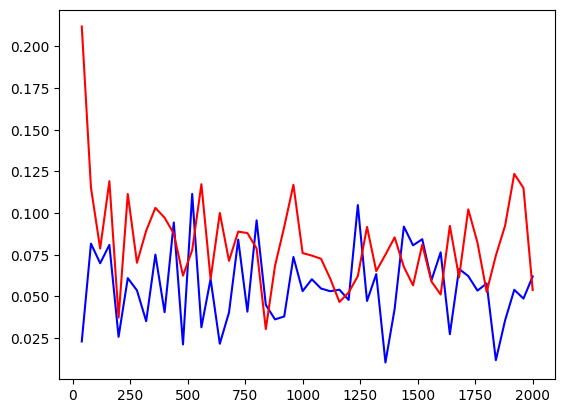

In [6]:
plt.plot(iteration_array, loss_array, 'blue')
plt.plot(iteration_array, val_loss_array, 'red')


#weight decay

0.44286543
0.3376894
7.773666666666667


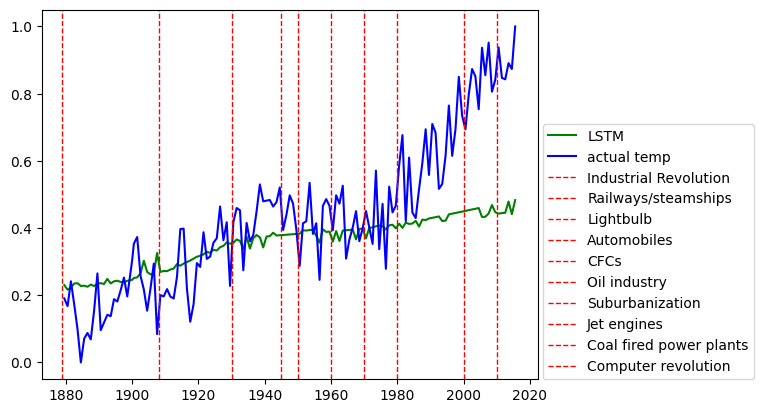

In [7]:
#Important historical dates for innovation
#1760 - Industrial revolution begins
#1800 - Expansion of railways and steamships
#1879 - Invention of the lightbulb
#1908 - Mass production of automobiles
#1930 - Developement of synthetic chemicals (CFCs)
#1945 - Rise of the oil industry
#1950 - Expansion of the Suburbs
#1960 - Introduction of jet engines
#1970 - Introduction of coal fired power plants
#1980 - Advent of computer and digital revolution
#2000 - Expansion of the internet and Data centres (internet, cloud computing etc)
#2010 - Rise of cryptocurrencies


max_temp = poly_model.forward(torch.tensor(max(Cleaned_cummulative_days), dtype = torch.float32).reshape(-1,1,1)).detach().numpy()[0][0]
min_temp = poly_model.forward(torch.tensor(min(Cleaned_cummulative_days), dtype = torch.float32).reshape(-1,1,1)).detach().numpy()[0][0]
print(max_temp)
print(min_temp)

#renormalise the model #convert the cumulatibe_days to years
#plt.plot(Cleaned_cummulative_days/365 + 1750 , poly_model.forward(torch.tensor(normalised_Cummulative_days, dtype = torch.float32).reshape(-1,1,1)).detach().numpy()*(max(Cleaned_mean_temp) -  min(Cleaned_mean_temp)) + min(Cleaned_mean_temp), color = "green", label = "LSTM")
#plt.plot(Cleaned_cummulative_days/365 + 1750 , Cleaned_mean_temp, color = 'blue', label = "actual temp")

plt.plot(Cleaned_cummulative_days/365 + 1750 , poly_model.forward(torch.tensor(normalised_Cummulative_days, dtype = torch.float32).reshape(-1,1,1)).detach().numpy(), color = "green", label = "LSTM")
plt.plot(Cleaned_cummulative_days/365 + 1750 , normalised_Mean_temp, color = 'blue', label = "actual temp")


historical_innovation = [1879,1908,1930,1945,1950,1960,1970,1980,2000,2010]#[1760,1800,1879,1908,1930,1945,1950,1960,1970,1980,2000,2010]
innovation_labels = ['Industrial Revolution', 'Railways/steamships', 'Lightbulb', 'Automobiles', 
                     'CFCs', 'Oil industry', 'Suburbanization', 'Jet engines', 'Coal fired power plants', 'Computer revolution', 'Internet expansion', 'Cryptocurrencies']
colors = ['red']
for x, label in zip(historical_innovation, innovation_labels):#, colors):
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1, label = label)

plt.legend(loc = (1.01,0))
print(min(Cleaned_mean_temp))

torch.Size([2, 3, 1])


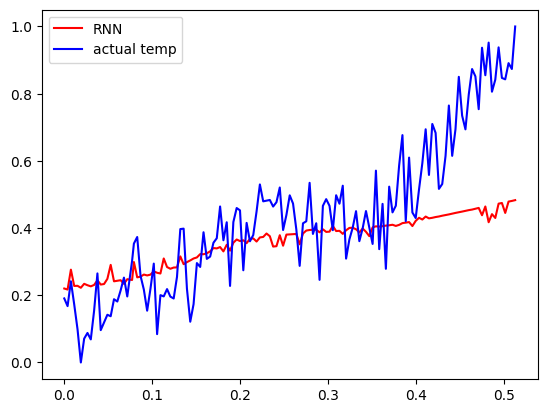

In [8]:
divisor = 1
print(val_X.shape)
#print(Days_test.reshape(-1,1).shape)

#plt.plot(normalised_Cummulative_days[::divisor], np.fft.ifft(poly_model.forward(torch.tensor(normalised_Cummulative_days, dtype = torch.float32).reshape(-1,1,1)).detach().numpy()[::divisor]), color = "red", label = "RNN")
#plt.plot(normalised_Cummulative_days[::divisor], np.fft.ifft(normalised_Mean_temp[::divisor]), color = 'blue', label = "actual temp")
#plt.legend()
#plt.show()
plt.plot(normalised_Cummulative_days[::divisor], poly_model.forward(torch.tensor(normalised_Cummulative_days, dtype = torch.float32).reshape(-1,1,1)).detach().numpy()[::divisor], color = "red", label = "RNN")
plt.plot(normalised_Cummulative_days[::divisor], normalised_Mean_temp[::divisor], color = 'blue', label = "actual temp")
plt.legend()